<a href="https://colab.research.google.com/github/andrecm0/RNA-Power-Flow/blob/main/TG_Andr%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curva de Carga

In [ ]:
!pip install pandapower


ERROR: Operation cancelled by user


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Curva_de_Carga_Sudeste_2023.csv to Curva_de_Carga_Sudeste_2023.csv


In [ ]:
import pandas as pd

curva = pd.read_csv("Curva_de_Carga_Sudeste_2023.csv", parse_dates=['din_instante'])
curva.head()


,Unnamed: 0,din_instante,hora,dia_semana,mes,carga_mw
0,3,2023-01-01 00:00:00,0,6,1,32183.885
1,7,2023-01-01 01:00:00,1,6,1,32196.682
2,11,2023-01-01 02:00:00,2,6,1,31539.570
3,15,2023-01-01 03:00:00,3,6,1,30699.367
4,19,2023-01-01 04:00:00,4,6,1,30126.195


In [ ]:
curva['fator_carga'] = curva['carga_mw'] / curva['carga_mw'].max()


# IEEE 14 Barras

In [ ]:
import pandapower.networks as pn
import pandapower as pp

# Carrega o sistema IEEE 14 barras
net = pn.case14()

pp.runpp(net)

# Tensões nas barras
display(net.res_bus[['vm_pu', 'va_degree']])




,vm_pu,va_degree
0,1.060000,0.000000
1,1.045000,-4.982589
2,1.010000,-12.725100
3,1.017671,-10.312901
4,1.019514,-8.773854
5,1.070000,-14.220946
6,1.061520,-13.359627
7,1.090000,-13.359627
8,1.055932,-14.938521
9,1.050985,-15.097288


In [ ]:
import pandapower.networks as pn
net = pn.case14()


fator = 1.3  # 30% a mais
net.load['p_mw'] *= fator
net.load['q_mvar'] *= fator
net.gen['p_mw'] *= fator

display(net.gen)
display(net.load)

# Executa o fluxo de potência
pp.runpp(net)

# Tensões por barra
display(net.res_bus[["vm_pu", "va_degree"]])

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,controllable,max_p_mw,min_p_mw
0,None,1,52.0,1.045,NaN,-40.0,50.0,1.0,False,True,0.0,None,True,140.0,0.0
1,None,2,0.0,1.010,NaN,0.0,40.0,1.0,False,True,0.0,None,True,100.0,0.0
2,None,5,0.0,1.070,NaN,-6.0,24.0,1.0,False,True,0.0,None,True,100.0,0.0
3,None,7,0.0,1.090,NaN,-6.0,24.0,1.0,False,True,0.0,None,True,100.0,0.0


,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type,controllable
0,None,1,28.21,16.51,0.0,0.0,NaN,1.0,True,None,False
1,None,2,122.46,24.70,0.0,0.0,NaN,1.0,True,None,False
2,None,3,62.14,-5.07,0.0,0.0,NaN,1.0,True,None,False
3,None,4,9.88,2.08,0.0,0.0,NaN,1.0,True,None,False
4,None,5,14.56,9.75,0.0,0.0,NaN,1.0,True,None,False
5,None,8,38.35,21.58,0.0,0.0,NaN,1.0,True,None,False
6,None,9,11.70,7.54,0.0,0.0,NaN,1.0,True,None,False
7,None,10,4.55,2.34,0.0,0.0,NaN,1.0,True,None,False
8,None,11,7.93,2.08,0.0,0.0,NaN,1.0,True,None,False
9,None,12,17.55,7.54,0.0,0.0,NaN,1.0,True,None,False


,vm_pu,va_degree
0,1.060000,0.000000
1,1.045000,-6.691373
2,1.010000,-17.055753
3,1.008376,-13.693516
4,1.010743,-11.677857
5,1.070000,-18.947360
6,1.052193,-17.686414
7,1.090000,-17.686414
8,1.041700,-19.764241
9,1.036903,-19.993325


# Integrando a Curva de Carga

In [ ]:
import copy
import time
import pandas as pd
import pandapower as pp
import pandapower.networks as pn

# Carregando sistema base
base_net = pn.case14()

# Gerar cenários e medir tempo
cenarios = []
#fatores_carga = [0.8, 0.9, 1.0, 1.1, 1.2]  # Fatores de carga

start_solver = time.time()  # início da contagem de tempo

# Gerar cenários

for i, row in curva.iterrows():
    net = copy.deepcopy(base_net)

    fator = row['fator_carga']
    net.load['p_mw'] *= fator
    net.load['q_mvar'] *= fator

    pp.runpp(net)

    entrada = {
        **{f'load_p_mw_{i}': p for i, p in enumerate(net.load['p_mw'])},
        **{f'load_q_mvar_{i}': q for i, q in enumerate(net.load['q_mvar'])},
        **{f'gen_vm_pu_{i}': v for i, v in enumerate(net.gen['vm_pu'])},
        'hora': row['hora'],
        'dia_semana': row['dia_semana'],
        'mes': row['mes']
    }

    saida = {
        **{f'bus_vm_pu_{i}': v for i, v in enumerate(net.res_bus['vm_pu'])},
    }

    cenario = {**entrada, **saida}
    cenarios.append(cenario)
solver_total_time = time.time() - start_solver  # fim da contagem
print(f"Tempo total solver para {len(curva)} casos: {solver_total_time:.2f} segundos")

# Criar DataFrame e salvar
cenarios_df = pd.DataFrame(cenarios)
cenarios_df.to_csv('cenarios_ieee14_completos_com_fatores.csv', index=False)
print("Cenários com fatores de carga salvos com sucesso!")


Tempo total solver para 8760 casos: 538.12 segundos
Cenários com fatores de carga salvos com sucesso!


# Pré-Processamento

In [ ]:
# O StandardScaler é uma ferramenta da biblioteca scikit-learn usada para padronizar dados. Ele transforma as variáveis para que tenham:
# média (mean) = 0
# desvio padrão (std) = 1

from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib

# 1. Carregar os dados
df = pd.read_csv('cenarios_ieee14_completos_com_fatores.csv')

# 2. Separar entradas e saídas
colunas_entrada = [col for col in df.columns if (
    col.startswith('load_p_mw_') or
    col.startswith('load_q_mvar_') or
    col.startswith('gen_vm_pu_') or
    col in ['hora', 'dia_da_semana', 'mes']
)]

colunas_saida = [col for col in df.columns if
    col.startswith('bus_vm_pu_') ]

X = df[colunas_entrada].values
y = df[colunas_saida].values

# 3. Normalizar entradas (StandardScaler é recomendado para RNA com ReLU ou Linear)
scaler_X = StandardScaler()
X_normalizado = scaler_X.fit_transform(X)

# 4. Salvar os arrays e o scaler
np.save('X_normalizado.npy', X_normalizado)
np.save('y_saida.npy', y)
joblib.dump(scaler_X, 'scaler_X.pkl')

print("Pré-processamento concluído com sucesso. Dados prontos para treinar a RNA.")


Pré-processamento concluído com sucesso. Dados prontos para treinar a RNA.


# Grid Search (Hiperparâmetros)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import itertools
import pandas as pd
from tensorflow.keras import Input

# -------------------------------
# 1) Carregar dados
# -------------------------------
X = np.load('X_normalizado.npy')
y = np.load('y_saida.npy')

# Garantir que y seja 2D: (n amostras, n_saidas)
if y.ndim == 1:
    y = y.reshape(-1, 1)

# -------------------------------
# 2) Normalizar y e salvar scaler
# -------------------------------
scaler_y = StandardScaler()
y_normalizado = scaler_y.fit_transform(y)
joblib.dump(scaler_y, 'scaler_y.pkl')
print("Scaler de y salvo como 'scaler_y.pkl'.")

# -------------------------------
# 3) Split
# -------------------------------
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_normalizado, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42
)

# (opcional) salvar conjuntos
np.save('X_train.npy', X_train)
np.save('X_val.npy',   X_val)
np.save('X_test.npy',  X_test)
np.save('y_train.npy', y_train)
np.save('y_val.npy',   y_val)
np.save('y_test.npy',  y_test)
print("Conjuntos de dados salvos com sucesso.")

# --------------------------------------------------
# → GRID SEARCH (treino com MAE; métricas extras)
# --------------------------------------------------
ativacoes  = ['linear', 'relu', 'tanh']
neurons    = [32, 64, 128, 256, 512]
num_layers = [1, 2, 3, 4, 5]

resultados = []
best_mae_real = np.inf  # para salvar o melhor modelo por MAE real
scaler_y = joblib.load('scaler_y.pkl')

for ativacao, n_neuronios, camadas in itertools.product(ativacoes, neurons, num_layers):
    print(f"\n🔧 Testando: ativação={ativacao}, neurônios={n_neuronios}, camadas={camadas}")

    # Modelo
    modelo = Sequential()
    modelo.add(Input(shape=(X_train.shape[1],)))
    modelo.add(Dense(n_neuronios, activation=ativacao))
    for _ in range(camadas - 1):
        modelo.add(Dense(n_neuronios, activation=ativacao))
    modelo.add(Dense(y_train.shape[1], activation='linear'))

    # Treinar APENAS com MAE
    modelo.compile(optimizer='adam', loss='mae', metrics=['mae'])

    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    modelo.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )

    # Avaliação em escala normalizada
    loss_mae_norm, mae_norm = modelo.evaluate(X_test, y_test, verbose=0)

    # Predição e métricas em ESCALA REAL (desnormalizada)
    y_pred_norm = modelo.predict(X_test, verbose=0)
    y_pred_real = scaler_y.inverse_transform(y_pred_norm)
    y_test_real = scaler_y.inverse_transform(y_test)

    # MAE real
    mae_real = mean_absolute_error(y_test_real, y_pred_real)
    # RMSE real
    rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    # R² (médio entre saídas, se multivariado)
    r2 = r2_score(y_test_real, y_pred_real, multioutput='uniform_average')

    print(f"MAE (norm): {mae_norm:.6f} | MAE (real): {mae_real:.6f} | RMSE (real): {rmse_real:.6f}")

    resultados.append({
        'ativacao': ativacao,
        'neurônios': n_neuronios,
        'camadas': camadas,
        'mae_normalizado': mae_norm,
        'mae_real': mae_real,
        'rmse_real': rmse_real,
    })


# DataFrame e ordenação
df = pd.DataFrame(resultados)

# Ordenar por MAE real (asc), depois RMSE (asc)
df = df.sort_values(by=['mae_real', 'rmse_real'], ascending=[True, True, False])

print("\n📊 Top 10 modelos (por MAE real, desempate por RMSE):")
print(df.head(10))

df.to_csv('resultados_comparativos.csv', index=False)
print("Resultados salvos em 'resultados_comparativos.csv'.")


Scaler de y salvo como 'scaler_y.pkl'.
Conjuntos de dados salvos com sucesso.

🔧 Testando: ativação=linear, neurônios=32, camadas=1
MAE (norm): 0.008833 | MAE (real): 0.000724 | RMSE (real): 0.001515

🔧 Testando: ativação=linear, neurônios=32, camadas=2
MAE (norm): 0.009431 | MAE (real): 0.001389 | RMSE (real): 0.002777

🔧 Testando: ativação=linear, neurônios=32, camadas=3
MAE (norm): 0.008562 | MAE (real): 0.000604 | RMSE (real): 0.001349

🔧 Testando: ativação=linear, neurônios=32, camadas=4
MAE (norm): 0.008445 | MAE (real): 0.000556 | RMSE (real): 0.001298

🔧 Testando: ativação=linear, neurônios=32, camadas=5
MAE (norm): 0.009593 | MAE (real): 0.001820 | RMSE (real): 0.004583

🔧 Testando: ativação=linear, neurônios=64, camadas=1
MAE (norm): 0.009844 | MAE (real): 0.001659 | RMSE (real): 0.003607

🔧 Testando: ativação=linear, neurônios=64, camadas=2
MAE (norm): 0.008070 | MAE (real): 0.000288 | RMSE (real): 0.000638

🔧 Testando: ativação=linear, neurônios=64, camadas=3
MAE (norm): 0.

ValueError: Length of ascending (3) != length of by (2)

# Analisando o Grid Search

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar resultados
df = pd.read_csv('resultados_comparativos.csv')

# Gráfico 1: Boxplot com todas as funções de ativação
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='ativacao', y='mae_real', palette='Set2')
plt.title('Distribuição do MAE por função de ativação')
plt.xlabel('Função de Ativação')
plt.ylabel('MAE')
plt.grid(True)
plt.tight_layout()
plt.show()

# Filtrar apenas para função ReLU
df_relu = df[df['ativacao'] == 'relu']

# Gráfico 2: MAE médio por quantidade de neurônios (somente ReLU)
plt.figure(figsize=(6, 4))
sns.lineplot(data=df_relu.sort_values('neurônios'), x='neurônios', y='mae_real', marker='o', ci=None)
plt.title('MAE médio por quantidade de neurônios (ReLU)')
plt.xlabel('Número de Neurônios')
plt.ylabel('MAE')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 3: MAE médio por número de camadas (somente ReLU)
plt.figure(figsize=(6, 4))
sns.lineplot(data=df_relu.sort_values('camadas'), x='camadas', y='mae_real', marker='s', ci=None)
plt.title('MAE médio por número de camadas (ReLU)')
plt.xlabel('Número de Camadas')
plt.ylabel('MAE')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 4: Heatmap (somente ReLU)
pivot_relu = df_relu.pivot_table(index='neurônios', columns='camadas', values='mae_real', aggfunc='mean')

plt.figure(figsize=(6, 4))
sns.heatmap(pivot_relu, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'label': 'MAE'})
plt.title('Heatmap do MAE médio para função ReLU (Neurônios vs Camadas)')
plt.xlabel('Número de Camadas')
plt.ylabel('Número de Neurônios')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Carrega os resultados
df = pd.read_csv('resultados_comparativos.csv')

# Filtra os dados para incluir apenas os valores desejados
df_filtrado = df[
    (df['camadas'].isin([1, 2, 3, 4, 5])) &
    (df['neurônios'].isin([32, 64, 128, 256, 512]))
]

# Prepara os dados
x = df_filtrado['neurônios']
y = df_filtrado['camadas']
z = df_filtrado['mae_real']

# Cria a figura 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plota os pontos
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', s=60)

# Eixos
ax.set_xlabel('Neurônios por camada')
ax.set_ylabel('Número de camadas')
ax.set_zlabel('MAE')

# Barra de cores
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('MAE')

# Título
plt.title('Desempenho da MLP: Neurônios vs Camadas vs MAE')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Carregar os dados
df = pd.read_csv('resultados_comparativos.csv')

# Filtrar apenas os dados com função de ativação ReLU
df_relu = df[df['ativacao'] == 'relu']

# Gráfico 3D interativo com Plotly
fig = px.scatter_3d(
    df_relu,
    x='neurônios',
    y='camadas',
    z='mae_real',
    color='mae_real',
    color_continuous_scale='viridis',
    title='Desempenho da MLP com ReLU: Neurônios vs Camadas vs MAE',
    labels={'neurônios': 'Neurônios por camada', 'camadas': 'Número de camadas', 'mae_real': 'MAE'},
    size_max=10
)

# Layout
fig.update_traces(marker=dict(size=6))
fig.update_layout(scene=dict(
    xaxis_title='Neurônios por camada',
    yaxis_title='Número de camadas',
    zaxis_title='MAE'
))
fig.show()


#Previsão x Real


# Random Forest

🎯 Treinando modelo vencedor...
✅ Treinamento concluído.
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

⏱️ Tempo total da RNA para 8760 entradas: 0.8255 segundos

📊 Comparação de desempenho:
- Solver tradicional: 3169.24 segundos
- Rede neural (inferência): 0.83 segundos
- A RNA foi aproximadamente 3839.34 vezes mais rápida

🌲 Analisando importância das entradas com Random Forest...

🔎 Top 10 variáveis mais importantes na precisão da RNA:
         Variavel  Importancia
13  load_q_mvar_2     0.365006
6     load_p_mw_6     0.042960
20  load_q_mvar_9     0.040221
17  load_q_mvar_6     0.034523
15  load_q_mvar_4     0.033586
16  load_q_mvar_5     0.033131
10   load_p_mw_10     0.030494
4     load_p_mw_4     0.030282
11  load_q_mvar_0     0.028513
9     load_p_mw_9     0.028390


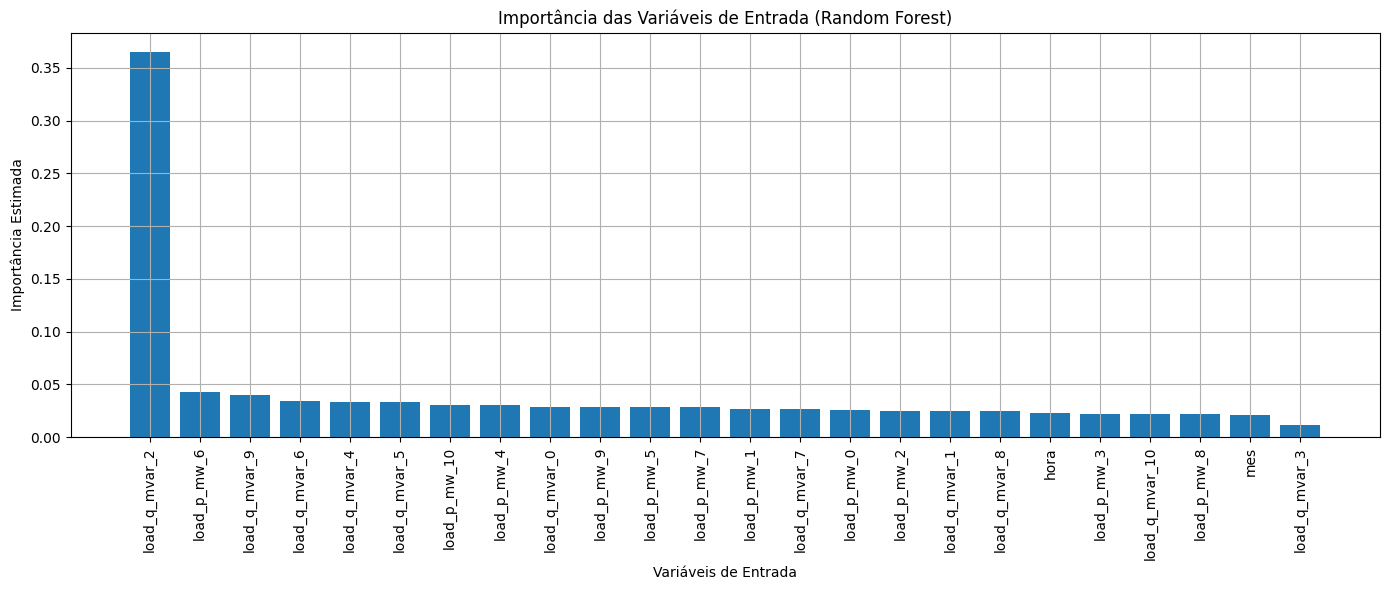


💾 Arquivo 'importancia_variaveis.csv' salvo com sucesso.


In [ ]:
import numpy as np
import time
import joblib
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# ----------------------------
# PARTE 1: Preparar dados
# ----------------------------

X = np.load('X_normalizado.npy')
y = np.load('y_saida.npy')
scaler_y = joblib.load('scaler_y.pkl')
y_normalizado = scaler_y.transform(y)

# Carregar nomes das colunas de entrada a partir do CSV original
df = pd.read_csv('cenarios_ieee14_completos_com_fatores.csv')
colunas_entrada = [col for col in df.columns if (
    col.startswith('load_p_mw_') or
    col.startswith('load_q_mvar_') or
    col in ['hora', 'dia_da_semana', 'mes']
)]

# ----------------------------
# PARTE 2: Treinar modelo RNA
# ----------------------------

modelo = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(y.shape[1], activation='linear')
])

modelo.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("🎯 Treinando modelo vencedor...")
modelo.fit(X, y_normalizado, epochs=100, batch_size=32, verbose=0)
print("✅ Treinamento concluído.")

# ----------------------------
# PARTE 3: Inferência RNA
# ----------------------------

start_time = time.time()
y_pred_normalizado = modelo.predict(X)
nn_total_time = time.time() - start_time

y_pred = scaler_y.inverse_transform(y_pred_normalizado)

print(f"\n⏱️ Tempo total da RNA para {X.shape[0]} entradas: {nn_total_time:.4f} segundos")

# ----------------------------
# PARTE 4: Comparar tempo com solver
# ----------------------------

solver_total_time = 3169.24  # substitua com o valor real medido

print(f"\n📊 Comparação de desempenho:")
print(f"- Solver tradicional: {solver_total_time:.2f} segundos")
print(f"- Rede neural (inferência): {nn_total_time:.2f} segundos")
print(f"- A RNA foi aproximadamente {solver_total_time / nn_total_time:.2f} vezes mais rápida")

# ----------------------------
# PARTE 5: Random Forest para importância das variáveis
# ----------------------------

print("\n🌲 Analisando importância das entradas com Random Forest...")

# Calcular erro absoluto da RNA por amostra
erro_abs = np.abs(y - y_pred)
erro_medio = erro_abs.mean(axis=1) if erro_abs.ndim > 1 else erro_abs

# Treinar Random Forest para prever erro da RNA com base nas entradas
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, erro_medio)

# Importâncias com nomes reais
importancias = rf.feature_importances_
df_importancia = pd.DataFrame({
    'Variavel': colunas_entrada,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Exibir top 10
print("\n🔎 Top 10 variáveis mais importantes na precisão da RNA:")
print(df_importancia.head(10))

# Plot
plt.figure(figsize=(14, 6))
plt.bar(df_importancia['Variavel'], df_importancia['Importancia'])
plt.xticks(rotation=90)
plt.xlabel('Variáveis de Entrada')
plt.ylabel('Importância Estimada')
plt.title('Importância das Variáveis de Entrada (Random Forest)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Salvar CSV
df_importancia.to_csv('importancia_variaveis.csv', index=False)
print("\n💾 Arquivo 'importancia_variaveis.csv' salvo com sucesso.")


# Avaliação

Scaler de y salvo como 'scaler_y.pkl'.
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


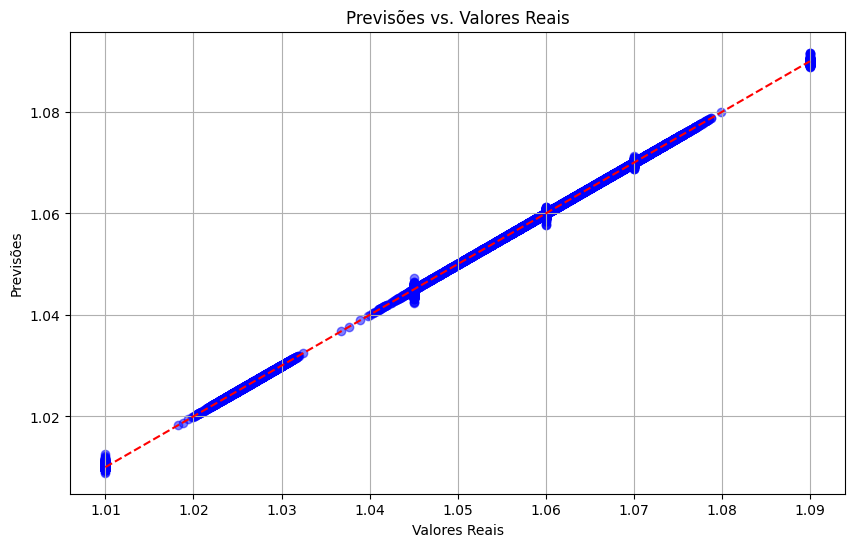

In [ ]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Carregar dados
X = np.load('X_normalizado.npy')
y = np.load('y_saida.npy')

# 2. Normalizar y
scaler_y = StandardScaler()
y_normalizado = scaler_y.fit_transform(y)

# 3. Salvar o scaler para uso posterior
joblib.dump(scaler_y, 'scaler_y.pkl')
print("Scaler de y salvo como 'scaler_y.pkl'.")

# Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_normalizado, test_size=0.2, random_state=42)

# Modelo
modelo = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(y.shape[1], activation='linear')
])
modelo.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelo.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0)

# Inferência
y_pred_normalizado = modelo.predict(X_test)
y_previsto_original = scaler_y.inverse_transform(y_pred_normalizado)
y_test_original = scaler_y.inverse_transform(y_test)

# Gráfico: Previsões vs Valores Reais
plt.figure(figsize=(10,6))
plt.scatter(y_test_original, y_previsto_original, color='blue', alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         color='red', linestyle='--')
plt.title('Previsões vs. Valores Reais')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.grid(True)
plt.show()
